# Predicción de atraso

Dado un vuelo, podemos conocer desde antemano su fecha planificada y sus caracteristicas asociadas, la aerolinea que opera, su destino y la densidad de vuelos programados para cada día.

Buscamos predecir si un vuelo va a tener un atraso mayor a 15 minutos.

Sabemos a priori que el 18.4% de los vuelos se atrasan más de 15 minutos, mientras que un 81.6% de los vuelos no se atrasan.

La variable objetivo `atraso_15` tiene un valor 1 si el vuelo se atrasa, y un 0 en caso constrario.

Necesitamos un modelo que sea capaz de utilizar features booleanas (1 o 0) y númericas, y entregar un resultado booleano.

In [50]:
import pandas as pd

features_scl = pd.read_csv('../clean_data/synthetic_features.csv', parse_dates=['Fecha-I', 'Fecha-O'])

features_scl.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'temporada_alta', 'dif_min',
       'atraso_15', 'periodo_dia', 'hora', 'v_last_12', 'v_next_12',
       'v_last_6', 'v_next_6', 'v_last_3', 'v_next_3'],
      dtype='object')

## Features a utilizar

Empezaremos con una cantidad limitada de features para nuestro primer modelo, necesitamos realizar un tratamiento a nuestras features categoricas y númericas.
- Tipo de vuelo (nacional vs internacional) -> Nacional 1 y Internacional 0
- Temporada alta vs temporada baja -> alta 1 y baja 0
- Hora día: Mañana - Tarde - Noche -> One hot encoding
- Día de la semana -> One hot encoding
- Cantidad de vuelos programados últimas 6 horas -> Variable continua positiva (normalizar)
- Aerolinea -> One hot encoding

One-hot-encoding: Transformar variables categoricas en multiples variables booleanas.
Variable ciclica sinusoidal: Transformar fechas (día del año, día del mes, día de la semana) en seno y coseno para capturar orden y naturaleza ciclica en variables númericas.

In [51]:
features_scl.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'temporada_alta', 'dif_min',
       'atraso_15', 'periodo_dia', 'hora', 'v_last_12', 'v_next_12',
       'v_last_6', 'v_next_6', 'v_last_3', 'v_next_3'],
      dtype='object')

In [52]:
import numpy as np
# Tipo vuelo en variable booleana
features_scl['tipo_b'] = np.where(features_scl['TIPOVUELO']=='N', 1, 0)

In [53]:
periodo_dia_ohe = pd.get_dummies(features_scl['periodo_dia'])
features_scl = features_scl.join(periodo_dia_ohe)

In [54]:
dianom_ohe = pd.get_dummies(features_scl['DIANOM'])
features_scl = features_scl.join(dianom_ohe)

In [55]:
opera_ohe = pd.get_dummies(features_scl['OPERA'])
features_scl = features_scl.join(opera_ohe)

In [56]:
# mean normalization
features_scl['norm_v_last_6'] = (
    (
        features_scl['v_last_6'] -
        features_scl['v_last_6'].mean()
    ) / 
    features_scl['v_last_6'].std()
)

In [57]:
# Columns into model
model_columns = [
    'temporada_alta', 'tipo_b',
    'mañana', 'noche', 'tarde', 
    'Domingo', 'Jueves', 'Lunes', 'Martes',
    'Miercoles', 'Sabado', 'Viernes', 'norm_v_last_6',
    'Aerolineas Argentinas', 'Aeromexico',
    'Air Canada', 'Air France', 'Alitalia', 'American Airlines', 'Austral',
    'Avianca', 'British Airways', 'Copa Air', 'Delta Air', 'Gol Trans',
    'Grupo LATAM', 'Iberia', 'JetSmart SPA', 'K.L.M.', 'Lacsa',
    'Latin American Wings', 'Oceanair Linhas Aereas',
    'Plus Ultra Lineas Aereas', 'Qantas Airways', 'Sky Airline',
    'United Airlines',
]

X = features_scl.loc[:,model_columns]
y = features_scl['atraso_15']

## Modelo Regresión logistica binaria

Ejemplo: [Handling imbalanced data with class weights in logistic regression](https://analyticsindiamag.com/handling-imbalanced-data-with-class-weights-in-logistic-regression/)

Tenemos una salida de dos clases (atraso = 1, no atraso = 0). Algoritmo rápido, simple y fácil de interpretar.

Separar features y target (atraso_15) en dos grupos, uno para entrenar el modelo, y otro para evaluar el modelo. Podemos separar los registros de manera aleatoria, dado que todas las features se pueden conocer con anticipación. Y vamos a asumir que entre un año y otro las features de temporalidad se mantienen constantes.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

logreg = LogisticRegression(random_state=42, class_weight='balanced') # Unbalanced dataset
model = logreg.fit(X_train, y_train) # Fit model

y_pred = model.predict(X_test)

En la variable prediction tenemos los resultados de las predicciones para el modelo. Ahora tenemos que comprar las predicciones con los valores reales conocidos.

Conceptos importantes:
* True positive — for correctly precited event values
* True negative — for correctly predicted no-event values
* False positive — for incorrectly predicted event values
* False negative — for incorrectly predicted no-event values

Para evaluar el modelo utilizaremos una matriz de confusión, y obtener nuestra precisión TP/(TP+FP) y Recall TP/(TP+FN). Finalmente utilizaremos la métrica F1-score, que es la media armonica entre presición y recall, y nos ayuda en este caso donde nuestras clases están desbalanceadas

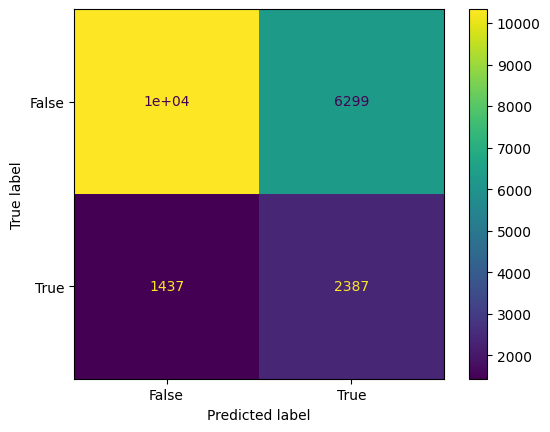

In [60]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [48]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
## Accuracy
print('Accuracy', round(accuracy_score(y_test, y_pred),3))
## Precision
print('Precision', round(precision_score(y_test, y_pred),3))
## Recall
print('Recall', round(recall_score(y_test, y_pred),3))
## F1 Score
print('F1 Score', round(f1_score(y_test, y_pred),3))

Accuracy 0.622
Precision 0.275
Recall 0.624
F1 Score 0.382


El modelo solo puede predecir correctamente un 62.4% (recall) de los atrasos reales.

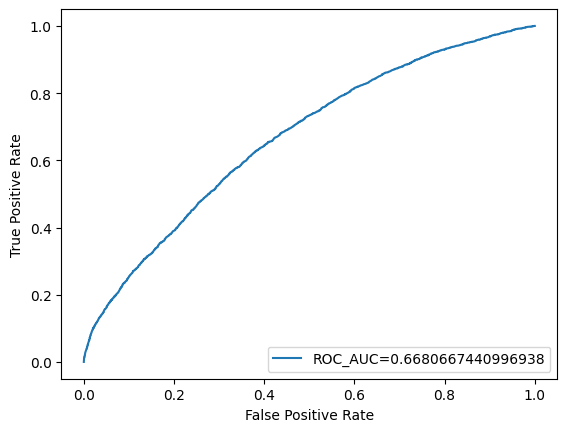

In [64]:
import matplotlib.pyplot as plt

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="ROC_AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

El modelo de regresión logistica tiene un score ROC_AUC de 0.668

El regresor lógistico puede capturar ciertos patrones, es mejor que un resultado aleatorio (roc_auc > 50%).

### Cuales son las variables que más influyen en la predicción?

Podemos considerar la magnitud de los coeficientes para cada parámetro en la data (considerar que todos los parámetros tienen una magnitud similar)

In [49]:
data = {'variable': X_train.columns.values, 'coeficiente': model.coef_[0]}
coeficientes = pd.DataFrame(data=data)
coeficientes.sort_values('coeficiente')

,variable,coeficiente
14,Aeromexico,-2.200372
23,Delta Air,-1.401966
35,United Airlines,-1.261101
28,K.L.M.,-1.136553
18,American Airlines,-1.123853
16,Air France,-0.956218
22,Copa Air,-0.753657
1,tipo_b,-0.712315
17,Alitalia,-0.697923
26,Iberia,-0.598730


Las variables que tienen un alto valor positivo o negativo en sus coeficientes del regresor tienen un mayor impacto en el modelo.

**La variable que más afecta la probabilidad de que un vuelo se atrase o no, es la areolinea que opera el vuelo.**

Otras caracteristicas importantes son: cantidad de vuelos programados en las últimas 6 horas, vuelo en dia viernes o domingo, vuelo en la tarde.

## ¿Cómo podrías mejorar la performance?

1. Se pueden añadir / quitar features según la importancia obtenida, para entrenar el modelo con una selección mas fina de variables.
2. Utilizar un modelo de mayor complejidad como Random Forest, XGBoost. Tenemos suficientes registros (>60k) para utilizar otro tipo de modelo.
3. Crear nuevas features que permitan capturar mejor ciertos patrones de vuelos atrasados.